In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import math

# dictionary
import sbr_team_name 

# Data

In [9]:
game_df = pd.read_csv('/Users/markusfiordaliso/Documents/coding_projects/pro_sports/nba_basketball/data/nba_scores_20150901_20210120.csv')
odds_df = pd.read_csv('/Users/markusfiordaliso/Documents/coding_projects/pro_sports/nba_basketball/data/nba_odds_20150901_20210120.csv')


## Tidy 

In [10]:
# odds_data

## remove unneccasary col
odd_col_keep = ['date', 'away_team', 'home_team', 'pinnacle1', 'pinnacle2']
odds_df = odds_df[odds_df.columns & odd_col_keep]

## date 
odds_df['date'] = pd.to_datetime(odds_df['date'], format = '%Y%m%d')

## rename book odds
odds_df.rename(columns={'pinnacle1' : 'away_odds', 'pinnacle2' : 'home_odds'}, inplace=True)

## covert text to lower case
odds_df = odds_df.apply(lambda x: x.str.lower() if(x.dtype== 'object') else x)

## restructure to vertical
home_odds = odds_df.iloc[:, [0, 1, 3]]
away_odds = odds_df.iloc[:, [0, 2, 4]]

home_odds.columns = ['date', 'team_name', 'odds']
away_odds.columns = ['date', 'team_name', 'odds']

odds_df = pd.concat([home_odds, away_odds])

## replace period in team name
odds_df['team_name'] = odds_df['team_name'].str.replace('.', '')

## team name cleanup to align to nba api
odds_df = odds_df.replace({'team_name' : sbr_team_name.sbr_dictionary})


In [11]:
# game_df

## covert text to lower case
game_df = game_df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
game_df.columns = map(str.lower, game_df.columns)

## date
game_df['game_date'] = pd.to_datetime(game_df['game_date'])

## add odds. NEED TO FIGURE OUT HOW TO DROP DATE COL AUTOMATICALLY
game_df = (pd
           .merge(game_df, odds_df,
                  left_on=['game_date', 'team_name'], right_on=['date', 'team_name'],
                  how='left',
                  copy=False))

# binary variables
game_df['game_won'] = np.where(game_df['wl'] == 'w', 1, 0)


# EDA

## Overview
Task: Research and evaluate what variables are good predictors of the outcome of an NBA game. Right now I am focusing solely on the regular season.

## Feature Engineer - First Attempt
There are a few variables that I know that I  want to add and evaluate right away

In [12]:
# home/away
game_df['home_team'] = game_df['matchup'].map(lambda x: 0 if '@' in x else 1)

# playing back to back
game_df = game_df.sort_values(['team_abbreviation', 'game_date'])
game_df['prior_game_date'] = game_df.groupby(['team_abbreviation'], as_index=False)['game_date'].shift(1)
game_df['prior_day_game'] = np.where(game_df['game_date'] - timedelta(days=1) == game_df['prior_game_date'], 1, 0)

# points against
game_df['pts_against'] = game_df['pts'] - game_df['plus_minus']


## Variable Correlation

In [13]:
#correlologram on specific variables...BREAK VAR INTO PRE GAME & IN GAME
corr_pre_game = ['game_won', 'odds', 'home_team', 'prior_day_game']

corr_in_game = ['game_won', 'pts', 'fgm', 'fga', 'fg_pct','fg3m', 'fg3a', 'fg3_pct',
                'ftm', 'fta', 'ft_pct', 'oreb', 'dreb','reb', 'ast', 'stl', 'blk',
                'tov', 'pf', 'plus_minus', 'pts_against']


Observation:

Multicollinearity doesn't appear to be evident in the pre game variables.

Multicollinearity is visible in the in game stats, which is expected since there are multiple stats that reflect a similar component. Example: fgm, fga, fg_pct, etc. are all a part of what determines pts. Obviously, I will not have access to these stats when building a predictive model prior to a game starting, but these stats may help me determine what variables are important in determinging the outcome of a game.



<AxesSubplot:title={'center':'Correlation matrix of pre-game variables'}>

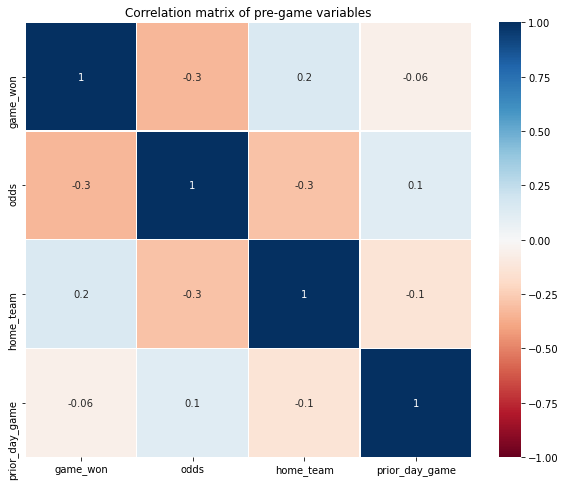

In [14]:
plt.figure(figsize=(10, 8))
plt.title('Correlation matrix of pre-game variables')

sns.heatmap(game_df.loc[:, corr_pre_game].corr(),
            annot=True,
            fmt = '.1g',
            center = 0,
            vmax=1,
            vmin=-1,
            cmap='RdBu',
            linewidths=0.2)

<AxesSubplot:title={'center':'Correlation matrix of in-game stats'}>

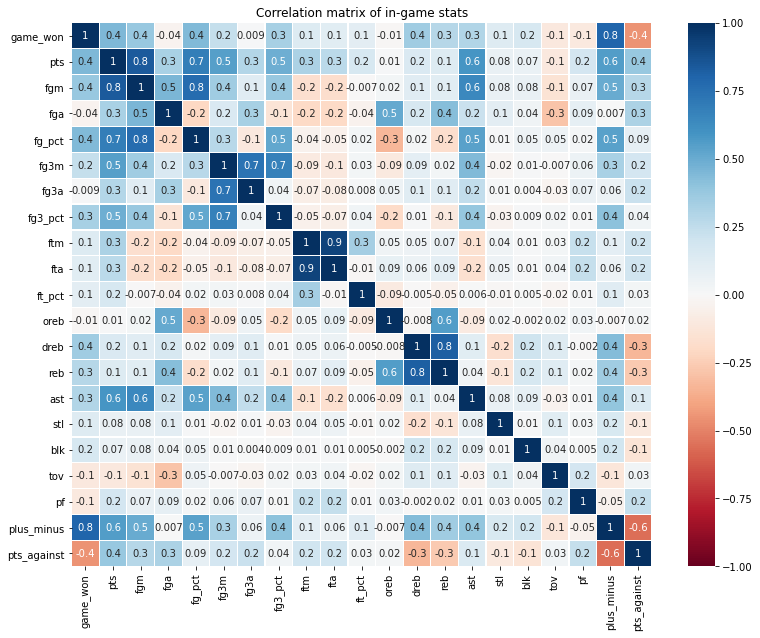

In [15]:
plt.figure(figsize=(13,10))
plt.title('Correlation matrix of in-game stats')

sns.heatmap(game_df.loc[:, corr_in_game].corr(),
            annot=True,
            fmt = '.1g',
            center = 0,
            vmax=1,
            vmin=-1,
            cmap='RdBu',
            linewidths=0.2)

## Odds - Sportsbook

<AxesSubplot:title={'center':'NBA Sportsbook Odds - Pinnacle'}, xlabel='odds', ylabel='Count'>

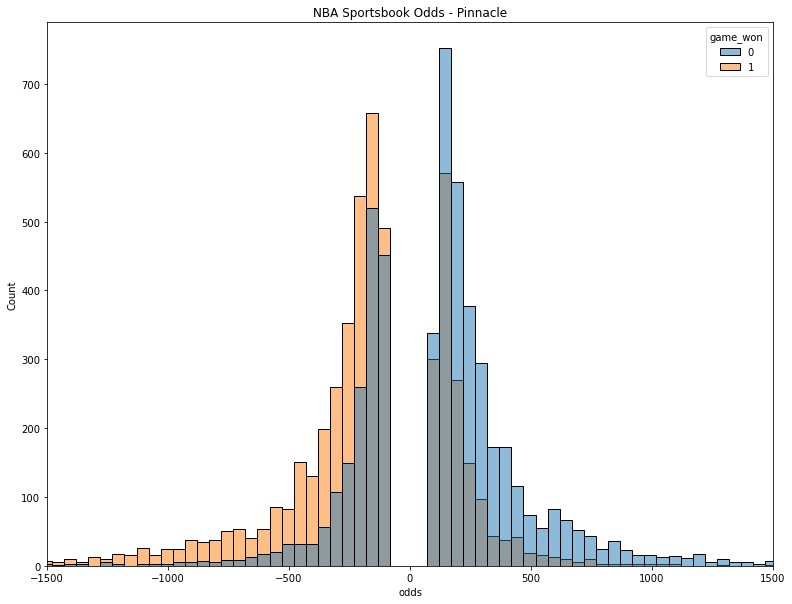

In [16]:
plt.figure(figsize=(13,10))
plt.xlim(-1500, 1500)
plt.title('NBA Sportsbook Odds - Pinnacle')

sns.histplot(game_df,
             x='odds',
             binwidth=50,
             hue='game_won')

In [17]:
# Create fav/und binary variable and look for groupings

## binary variable
game_id_group = (game_df
                 .groupby(['game_id'], as_index=False)['odds'])

game_df = (game_df
           .assign(max_game_odd = game_id_group.transform(max),
                   min_game_odd = game_id_group.transform(min)))

game_df['favorite'] = np.where((game_df['min_game_odd'] != game_df['max_game_odd']) & (game_df['odds'] == game_df['min_game_odd']), 1, 0)



In [18]:
## odd bin

game_df['odd_bin'] = pd.cut(game_df['odds'], bins = np.arange(-1000, 1000, 100), right=False)

odd_bin_win_summary = (game_df
                       .groupby(['odd_bin'])
                       .agg(win = ('game_won', sum),
                            ct = ('game_won', 'count'))
                       .reset_index()
                       .assign(win_prop = lambda x: x['win'] / x['ct']))

Using the graph below to help identify initial odd bins to further classify underdogs/favorites. I'm going to stick with 4 groups (large and small underdog/favorites) for now, as there doesn't appear to be more distinct groups based off the win percentages of each odd bin group.

<AxesSubplot:title={'center':'Odd Bin Win Percentage'}, xlabel='odd_bin', ylabel='win_prop'>

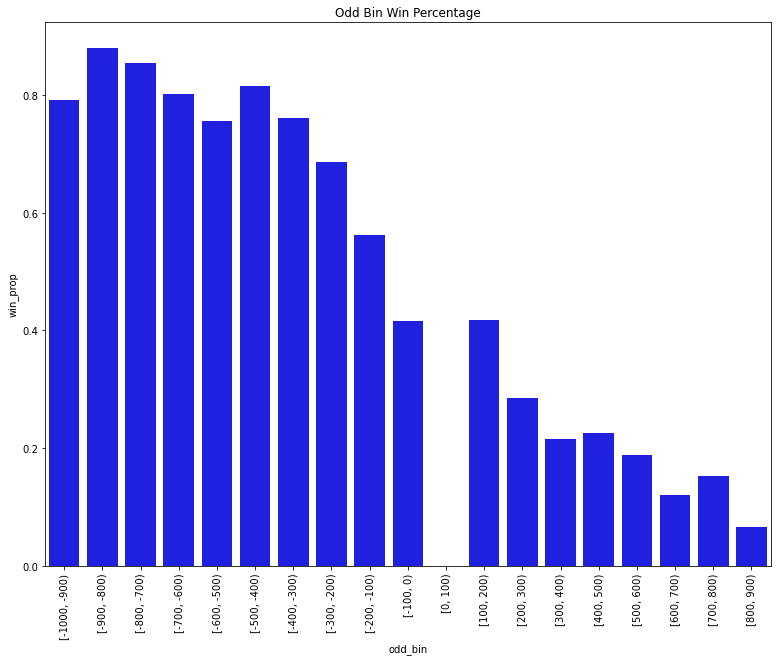

In [19]:
plt.figure(figsize=(13,10))
plt.title('Odd Bin Win Percentage')
plt.xticks(rotation = 90)

sns.barplot(data = odd_bin_win_summary,
            x='odd_bin',
            y='win_prop',
            color = 'blue')

In [20]:
# odd bin group functions
def odd_bin_group_fn(odds, favorite):
    if odds <= -200 and favorite == 1:
        return('large_favorite')
    elif odds > -200 and odds < 0 and favorite == 1:
        return('small_favorite')
    elif odds < 200 and odds > 0 and favorite == 0:
        return('small_underdog')
    elif odds >= 200 and favorite == 0:
        return('large_underdog')
    else:
        return('other')

In [21]:
game_df['odd_group'] = game_df.apply(lambda row: odd_bin_group_fn(row["odds"], row["favorite"]), axis=1)

In [22]:
# plot ct and win % by group

In [23]:
odd_group_win_summary = (game_df
                       .groupby('odd_group')
                       .agg(win = ('game_won', sum),
                            ct = ('game_won', 'count'))
                       .reset_index()
                       .assign(win_prop = lambda x: x['win'] / x['ct']))

# reorder
odd_group_win_summary['odd_group'] = pd.Categorical(odd_group_win_summary['odd_group'],
                                                    categories = ['large_favorite', 'small_favorite', 'small_underdog', 'large_underdog', 'other'],
                                                    ordered = True)


This graph shows the expected reduction in win probability over the odd bin groups

<AxesSubplot:title={'center':'Odd Bin Win Percentage'}, xlabel='odd_group', ylabel='win_prop'>

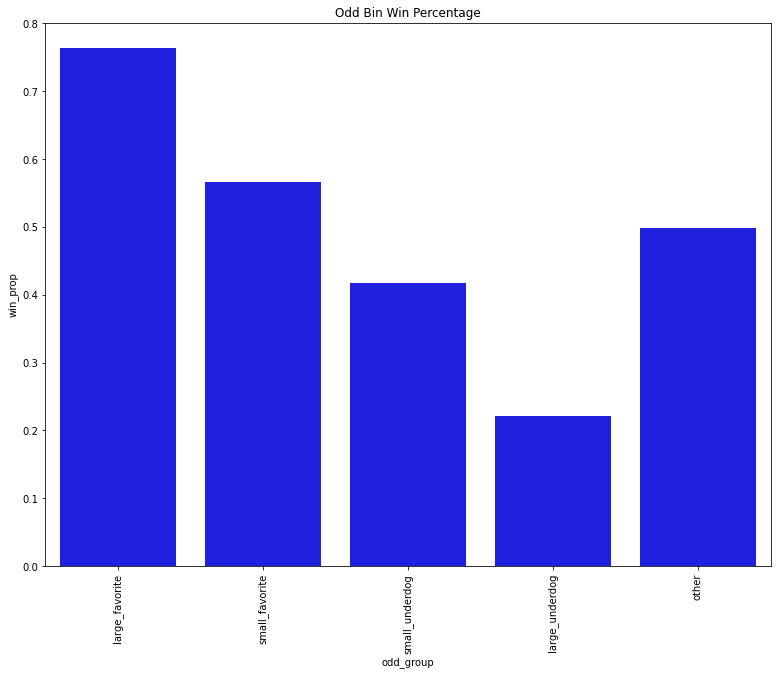

In [31]:
plt.figure(figsize=(13,10))
plt.title('Odd Bin Win Percentage')
plt.xticks(rotation = 90)

sns.barplot(data = odd_group_win_summary,
            x='odd_group',
            y='win_prop',
            color = 'blue')

## Recent Performance

In [51]:
def stat_moving_avg(df, k, column):
    val = (df
     .sort_values(by = ['team_id', 'game_date'])
     .groupby(['team_id'])[column]
     .transform(lambda x: x.rolling(k).mean()))
    
    return(val)

In [69]:
# define moving avg
k = 10

game_df['ppg_avg'] = stat_moving_avg(game_df, k, 'pts')
game_df['opp_ppg_avg'] = stat_moving_avg(game_df, k, 'pts_against')

In [72]:
game_df

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,pts,...,prior_day_game,pts_against,max_game_odd,min_game_odd,favorite,odd_bin,odd_group,ppg_ma,ppg_avg,opp_ppg_avg
12370,22015,1610612737,atl,atlanta hawks,21500001,2015-10-27,atl vs. det,l,239,94,...,0,106.0,256.0,-290.0,1,"[-300, -200)",large_favorite,NaN,NaN,NaN
12341,22015,1610612737,atl,atlanta hawks,21500019,2015-10-29,atl @ nyk,w,240,112,...,0,101.0,171.0,-185.0,1,"[-200, -100)",small_favorite,NaN,NaN,NaN
12318,22015,1610612737,atl,atlanta hawks,21500026,2015-10-30,atl vs. cha,w,241,97,...,1,94.0,161.0,-179.0,1,"[-200, -100)",small_favorite,NaN,NaN,NaN
12295,22015,1610612737,atl,atlanta hawks,21500039,2015-11-01,atl @ cha,w,240,94,...,0,92.0,122.0,-135.0,1,"[-200, -100)",small_favorite,NaN,NaN,NaN
12258,22015,1610612737,atl,atlanta hawks,21500055,2015-11-03,atl @ mia,w,239,98,...,0,92.0,153.0,-170.0,0,"[100, 200)",small_underdog,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,22020,1610612764,was,washington wizards,22000086,2021-01-03,was @ bkn,w,239,123,...,0,122.0,258.0,-301.0,0,"[200, 300)",large_underdog,114.2,114.2,117.9
190,22020,1610612764,was,washington wizards,22000109,2021-01-06,was @ phi,l,240,136,...,0,141.0,220.0,-252.0,0,"[200, 300)",large_underdog,117.5,117.5,119.9
175,22020,1610612764,was,washington wizards,22000124,2021-01-08,was @ bos,l,239,107,...,0,116.0,152.0,-170.0,0,"[100, 200)",small_underdog,116.9,116.9,118.9
155,22020,1610612764,was,washington wizards,22000136,2021-01-09,was vs. mia,l,240,124,...,1,128.0,412.0,-512.0,0,"[400, 500)",large_underdog,119.7,119.7,122.7


## Model

In [116]:
# filter on columns to simplify data
game_df_model_col = ['team_id', 'team_abbreviation', 'game_id', 'game_won', 'odd_group', 'ppg_avg', 'opp_ppg_avg', 'home_team']
game_df_model = game_df[game_df.columns.intersection(game_df_model_col)]

# restructure data to create single line game
game_df_model_h = game_df_model.loc[game_df_model['home_team'] == 1, :]
game_df_model_a = game_df_model.loc[game_df_model['home_team'] == 0, :]

game_df_model_h = game_df_model_h.add_suffix('_h')
game_df_model_a = game_df_model_a.add_suffix('_a')

game_df_model_final = (pd.merge(game_df_model_h, game_df_model_a,
                                left_on=['game_id_h'],
                                right_on=['game_id_a'],
                                how='left',
                                copy=False))

# filter out na ppg avg based of moving average
game_df_model_final = game_df_model_final.dropna()

In [ ]:
# build GBM model

,team_id_h,team_abbreviation_h,game_id_h,game_won_h,home_team_h,odd_group_h,ppg_avg_h,opp_ppg_avg_h,team_id_a,team_abbreviation_a,game_id_a,game_won_a,home_team_a,odd_group_a,ppg_avg_a,opp_ppg_avg_a
0,1610612737,atl,21500117,1,1,large_favorite,104.4,100.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1610612737,atl,21500148,0,1,small_favorite,102.7,99.7,1.610613e+09,uta,21500148.0,1.0,0.0,small_underdog,95.5,91.8
2,1610612737,atl,21500169,1,1,small_favorite,102.7,99.8,1.610613e+09,sac,21500169.0,0.0,0.0,small_underdog,100.3,106.5
3,1610612737,atl,21500210,1,1,small_favorite,104.6,102.5,1.610613e+09,bos,21500210.0,0.0,0.0,small_underdog,104.5,98.9
4,1610612737,atl,21500256,1,1,small_underdog,100.3,100.4,1.610613e+09,okc,21500256.0,0.0,0.0,small_favorite,104.2,99.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,1610612764,was,22000033,0,1,small_underdog,106.7,115.4,1.610613e+09,orl,22000033.0,1.0,0.0,small_favorite,115.2,115.0
6050,1610612764,was,22000050,0,1,large_favorite,106.4,115.1,1.610613e+09,chi,22000050.0,1.0,0.0,large_underdog,110.2,115.3
6051,1610612764,was,22000063,0,1,large_favorite,109.4,117.3,1.610613e+09,chi,22000063.0,1.0,0.0,large_underdog,112.0,115.8
6052,1610612764,was,22000136,0,1,large_underdog,119.7,122.7,1.610613e+09,mia,22000136.0,1.0,0.0,large_favorite,107.5,110.3


In [105]:
(pd.merge(game_df, odds_df,
                  left_on=['game_date', 'team_name'], right_on=['date', 'team_name'],
                  how='left',
                  copy=False))

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,pts,...,max_game_odd,min_game_odd,favorite,odd_bin,odd_group,ppg_ma,ppg_avg,opp_ppg_avg,date_y,odds_y
0,22015,1610612737,atl,atlanta hawks,21500001,2015-10-27,atl vs. det,l,239,94,...,256.0,-290.0,1,"[-300, -200)",large_favorite,NaN,NaN,NaN,2015-10-27,-290.0
1,22015,1610612737,atl,atlanta hawks,21500019,2015-10-29,atl @ nyk,w,240,112,...,171.0,-185.0,1,"[-200, -100)",small_favorite,NaN,NaN,NaN,2015-10-29,-185.0
2,22015,1610612737,atl,atlanta hawks,21500026,2015-10-30,atl vs. cha,w,241,97,...,161.0,-179.0,1,"[-200, -100)",small_favorite,NaN,NaN,NaN,2015-10-30,-179.0
3,22015,1610612737,atl,atlanta hawks,21500039,2015-11-01,atl @ cha,w,240,94,...,122.0,-135.0,1,"[-200, -100)",small_favorite,NaN,NaN,NaN,2015-11-01,-135.0
4,22015,1610612737,atl,atlanta hawks,21500055,2015-11-03,atl @ mia,w,239,98,...,153.0,-170.0,0,"[100, 200)",small_underdog,NaN,NaN,NaN,2015-11-03,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12371,22020,1610612764,was,washington wizards,22000086,2021-01-03,was @ bkn,w,239,123,...,258.0,-301.0,0,"[200, 300)",large_underdog,114.2,114.2,117.9,2021-01-03,258.0
12372,22020,1610612764,was,washington wizards,22000109,2021-01-06,was @ phi,l,240,136,...,220.0,-252.0,0,"[200, 300)",large_underdog,117.5,117.5,119.9,2021-01-06,220.0
12373,22020,1610612764,was,washington wizards,22000124,2021-01-08,was @ bos,l,239,107,...,152.0,-170.0,0,"[100, 200)",small_underdog,116.9,116.9,118.9,2021-01-08,152.0
12374,22020,1610612764,was,washington wizards,22000136,2021-01-09,was vs. mia,l,240,124,...,412.0,-512.0,0,"[400, 500)",large_underdog,119.7,119.7,122.7,2021-01-09,412.0


In [ ]:
# Future variables
## ELO instead of other stats below
## Avg PF, PA, 
## Recent Performance: W, PF, PA
## Odds: Fav/Und buckets
## Fatigue - OT prior game

# Build Simple Model
## Odd bin
## Home/Away
## prior day game
## recent ppg, pag